# Deep Learning - Exercise 9

This exercise focuses on implementing and utilizing transformer models using the HuggingFace library in conjunction with
TensorFlow 2. We'll explore how to leverage pre-trained models for natural language processing tasks.

**Core Concepts**

- 🤗 HuggingFace library and its ecosystem
- 🔧 Integration of HuggingFace models with TensorFlow 2
- 📊 Fine-tuning pre-trained models for specific NLP tasks
- 🚀 Practical applications of transformer models

The lecture is based on [official Huggingface tutorials](https://huggingface.co/transformers/v4.2.2/notebooks.html)


[Open in Google colab](https://colab.research.google.com/github/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_09.ipynb)
[Download from Github](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_09.ipynb)

##### Remember to set **GPU** runtime in Colab!


In [63]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import LSTM, GRU, Bidirectional

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, recall_score, precision_score
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_distances
import scipy
import itertools
import string
import re
import tqdm
import io

tf.version.VERSION

'2.19.0'

In [2]:
import transformers
from datasets import load_dataset, Dataset
from evaluate import load
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, create_optimizer, AutoModelForSequenceClassification
from transformers.keras_callbacks import KerasMetricCallback

print(transformers.__version__)

4.50.3


In [3]:
SEED = 13

# 📒 What is the main idea behind transformer models?

## The good news is that you already know most of the things from the Attention-focused lecture 🙂

- 💡 The main idea behind the transformer architecture is to use **self-attention mechanisms** to capture the
  relationships between different words in a sentence
- Self-attention allows the model to focus on different parts of the input sequence when processing each word in the
  sequence
  - This allows the model to take into account the context and dependencies between different words in the sequence,
    which is important for many NLP tasks

![att](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_008_meme_02.png?raw=true)

## 🔎 Is there any difference when you compare it to the RNN model? 🔎

- The main difference between the transformer architecture and recurrent neural networks (RNNs) is the way they handle
  sequential data
- RNNs process sequential data one element at a time, using hidden states to capture information about the previous
  elements in the sequence
  - In contrast, the transformer architecture processes the entire sequence at once, using self-attention mechanisms to
    capture dependencies between different elements in the sequence
- 💡 The transformer architecture is **easier parallelizable**.
  - 📌 The transformer architecture processes the entire sequence at once, it can be trained more efficiently on
    parallel hardware like GPUs


# ⚡ We will use the BERT model for sample classification task from the GLUE Benchmark

- We will test the model on CoLA dataset which is meant for classification as we need to label every sencente if it is
  grammatically correct or not

### 💡 You can use any of these datasets in this notebook for your experiments

- [CoLA](https://nyu-mll.github.io/CoLA/) (Corpus of Linguistic Acceptability) Determine if a sentence is grammatically
  correct or not.is a dataset containing sentences labeled grammatically correct or not.
- [MNLI](https://arxiv.org/abs/1704.05426) (Multi-Genre Natural Language Inference) Determine if a sentence entails,
  contradicts or is unrelated to a given hypothesis. (This dataset has two versions, one with the validation and test
  set coming from the same distribution, another called mismatched where the validation and test use out-of-domain
  data.)
- [MRPC](https://www.microsoft.com/en-us/download/details.aspx?id=52398) (Microsoft Research Paraphrase Corpus)
  Determine if two sentences are paraphrases from one another or not.
- [QNLI](https://rajpurkar.github.io/SQuAD-explorer/) (Question-answering Natural Language Inference) Determine if the
  answer to a question is in the second sentence or not. (This dataset is built from the SQuAD dataset.)
- [QQP](https://data.quora.com/First-Quora-Dataset-Release-Question-Pairs) (Quora Question Pairs2) Determine if two
  questions are semantically equivalent or not.
- [RTE](https://aclweb.org/aclwiki/Recognizing_Textual_Entailment) (Recognizing Textual Entailment) Determine if a
  sentence entails a given hypothesis or not.
- [SST-2](https://nlp.stanford.edu/sentiment/index.html) (Stanford Sentiment Treebank) Determine if the sentence has a
  positive or negative sentiment.
- [STS-B](http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark) (Semantic Textual Similarity Benchmark) Determine the
  similarity of two sentences with a score from 1 to 5.
- [WNLI](https://cs.nyu.edu/faculty/davise/papers/WinogradSchemas/WS.html) (Winograd Natural Language Inference)
  Determine if a sentence with an anonymous pronoun and a sentence with this pronoun replaced are entailed or not. (This
  dataset is built from the Winograd Schema Challenge dataset.)


## You just need to select any task from the list below

- 💡 The **batch_size** should be set according to your GPU memory

### We will use `distilbert-base-uncased` model

- 💡 The model is primarily aimed at being fine-tuned on tasks that use the whole sentence to make decisions, such as
  sequence classification
  - This model is uncased: it does not make a difference between english and English
- DistilBERT is a transformers model, smaller and faster than BERT, which was pretrained on the same corpus in a
  self-supervised fashion, using the BERT base model as a teacher
  - This means it was pretrained on the raw texts only, with no humans labelling them in any way with an automatic
    process to generate inputs and labels from those texts using the BERT base model
  - 💡 It "mimics" the original BERT outputs using a smaller, less demanding, model
- 📌 You can check https://huggingface.co/distilbert/distilbert-base-uncased for more details


In [4]:
GLUE_TASKS = [
    "cola",
    "mnli",
    "mrpc",
    "qnli",
    "qqp",
    "rte",
    "sst2",
    "stsb",
    "wnli",
]

task = "cola"
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

### We will use the `datasets` library to download the data and the `evaluate` library to get the metric we need to use for evaluation (to compare our model to the benchmark)

- This can be easily done with the `load_dataset` function from datasets and and the `load` function from evaluate


In [5]:
dataset = load_dataset("glue", task)
metric = load("glue", task)

- The `dataset` object itself is
  [DatasetDict](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains
  one key for the training, validation and test set


In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1063
    })
})

## We should always take a look at the example data


In [7]:
dataset["train"][0]

{'sentence': "Our friends won't buy this analysis, let alone the next one we propose.",
 'label': 1,
 'idx': 0}

In [8]:
dataset["train"][:5]

{'sentence': ["Our friends won't buy this analysis, let alone the next one we propose.",
  "One more pseudo generalization and I'm giving up.",
  "One more pseudo generalization or I'm giving up.",
  'The more we study verbs, the crazier they get.',
  'Day by day the facts are getting murkier.'],
 'label': [1, 1, 1, 1, 1],
 'idx': [0, 1, 2, 3, 4]}

In [9]:
dataset["test"][0]

{'sentence': 'Bill whistled past the house.', 'label': -1, 'idx': 0}

In [10]:
dataset["validation"][0]

{'sentence': 'The sailors rode the breeze clear of the rocks.',
 'label': 1,
 'idx': 0}

### The `metric` is an instance of [datasets.Metric](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Metric)

- 💡 It simplify the process of model evaluation so we don't have to use raw scikit-learn functions


In [11]:
metric

EvaluationModule(name: "glue", module_type: "metric", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = evaluate.load('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=ref

## You can call its compute method with your predictions and labels directly and it will return a dictionary with the metric(s) value

- 💡The metric is chosen by the task name we specified so we use the right metric for the benchmark


In [12]:
fake_preds = np.random.randint(0, 2, size=(64,))
fake_labels = np.random.randint(0, 2, size=(64,))
metric.compute(predictions=fake_preds, references=fake_labels)

{'matthews_correlation': np.float64(0.1536230967599611)}

## Preprocessing the data

- Before we can feed those texts to our model, we need to preprocess them. This is done by a Transformers `Tokenizer`
  which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in
  the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model
  requires

- 💡 To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

  - We get a tokenizer that corresponds to the model architecture we want to use
  - We download the vocabulary used when pretraining this specific checkpoint

- That vocabulary will be cached, so it's not downloaded again the next time we run the cell


In [13]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

## Nothing new here - just a regular word2id mapping 🤗


In [14]:
tokenizer("Hello, this is a sentence!", "And this sentence goes with it.")

{'input_ids': [101, 7592, 1010, 2023, 2003, 1037, 6251, 999, 102, 1998, 2023, 6251, 3632, 2007, 2009, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

### To preprocess our dataset, we will need the names of the columns containing the sentence(s)

- The following dictionary keeps track of the correspondence task to column names
  - 💡 Do you remember that sentence, label, idx dict?


In [15]:
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

sentence1_key, sentence2_key = task_to_keys[task]
if sentence2_key is None:
    print(f"Sentence: {dataset['train'][0][sentence1_key]}")
else:
    print(f"Sentence 1: {dataset['train'][0][sentence1_key]}")
    print(f"Sentence 2: {dataset['train'][0][sentence2_key]}")

Sentence: Our friends won't buy this analysis, let alone the next one we propose.


### We just feed them to the tokenizer with the arguments `truncation=True` and `padding='longest'`

- 💡 This will ensure that an input longer that what the model selected can handle will be truncated to the maximum
  length accepted by the model, and all inputs will be padded to the maximum input length to give us a single input
  array


In [16]:
def preprocess_function(examples):
    if sentence2_key is None:
        return tokenizer(examples[sentence1_key], truncation=True)
    return tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True)

## Using this code we can tokenize the sentences in our dataset

- To apply this function on all the sentences in our dataset, we just use the map method of our dataset object we
  created earlier
- 💡 This will apply the function on all the elements of all the splits in dataset, so our training, validation and
  testing data will be preprocessed in one single command


In [17]:
preprocess_function(dataset["train"][:5])

{'input_ids': [[101, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102], [101, 2028, 2062, 18404, 2236, 3989, 1998, 1045, 1005, 1049, 3228, 2039, 1012, 102], [101, 2028, 2062, 18404, 2236, 3989, 2030, 1045, 1005, 1049, 3228, 2039, 1012, 102], [101, 1996, 2062, 2057, 2817, 16025, 1010, 1996, 13675, 16103, 2121, 2027, 2131, 1012, 102], [101, 2154, 2011, 2154, 1996, 8866, 2024, 2893, 14163, 8024, 3771, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [18]:
pre_tokenizer_columns = set(dataset["train"].features)
encoded_dataset = dataset.map(preprocess_function, batched=True)
tokenizer_columns = list(set(encoded_dataset["train"].features) - pre_tokenizer_columns)
print("Columns added by tokenizer:", tokenizer_columns)

Columns added by tokenizer: ['attention_mask', 'input_ids']


## 🚀 Fine-tuning the model

- Now that our data is ready, we can download the pretrained model and fine-tune it
  - Since all our tasks are about sentence classification, we use the `TFAutoModelForSequenceClassification` class
- 💡 The only thing we have to specify is the number of labels for our dataset


In [19]:
num_labels = 3 if task.startswith("mnli") else 1 if task == "stsb" else 2
if task == "stsb":
    num_labels = 1
elif task.startswith("mnli"):
    num_labels = 3
else:
    num_labels = 2

# This next little bit is optional, but will give us cleaner label outputs later
# If you're using a task other than CoLA, you will probably need to change these
# to match the label names for your task!
id2label = {0: "Invalid", 1: "Valid"}
label2id = {val: key for key, val in id2label.items()}

model = TFAutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=num_labels, id2label=id2label, label2id=label2id
)

I0000 00:00:1745757981.051662   22949 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or bu

## ⚡ One of the last steps is to create a TF datasets which will feed the data into the model


In [20]:
validation_key = (
    "validation_mismatched"
    if task == "mnli-mm"
    else "validation_matched"
    if task == "mnli"
    else "validation"
)

tf_train_dataset = model.prepare_tf_dataset(
    encoded_dataset["train"],
    shuffle=True,
    batch_size=16,
    tokenizer=tokenizer
)

tf_validation_dataset = model.prepare_tf_dataset(
    encoded_dataset[validation_key],
    shuffle=False,
    batch_size=16,
    tokenizer=tokenizer,
)

## Compile the model and specify the optimizer


In [21]:
num_epochs = 3
batches_per_epoch = len(encoded_dataset["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)
model.compile(optimizer=optimizer)
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## The last thing we need to define is how to compute the metrics from the predictions

- We need to define a function for this, which will just use the metric we loaded earlier

  - 💡 The only preprocessing we have to do is to take the argmax of our predicted logits

- In addition, let's wrap this metric computation function in a `KerasMetricCallback`.
  - 💡 This callback will compute the metric on the validation set each epoch, including printing it and logging it for
    other callbacks like `EarlyStopping`.


In [22]:
def compute_metrics(eval_predictions):
    predictions, labels = eval_predictions
    if task != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)


metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_dataset)

## 🚀 We can finally fit the model!

- 💡 Make sure that you pass the TF datasets, and not the original ones!


In [23]:
callbacks = [metric_callback]

model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=num_epochs,
    callbacks=callbacks,
)

Epoch 1/3


I0000 00:00:1745757993.971267   23121 service.cc:152] XLA service 0x7f942c810140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745757993.971297   23121 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2025-04-27 14:46:33.976422: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745757993.991366   23121 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1745757994.107540   23121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


534/534 [==============================] - 78s 105ms/step - loss: 0.5157 - val_loss: 0.4556 - matthews_correlation: 0.4923
Epoch 2/3


2025-04-27 14:47:41.258798: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


534/534 [==============================] - 47s 87ms/step - loss: 0.3178 - val_loss: 0.4630 - matthews_correlation: 0.5373
Epoch 3/3
  2/534 [..............................] - ETA: 45s - loss: 0.2641

2025-04-27 14:48:28.033899: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


534/534 [==============================] - 44s 82ms/step - loss: 0.1890 - val_loss: 0.5479 - matthews_correlation: 0.5099


# Now we can do inference using our own inputs

- Now, let's make up some sentences and see if the model can classify them properly!
- The first sentence is valid English, but the second one makes a grammatical mistake.


In [24]:
sentences = [
    "The judge told the jurors to think carefully.",
    "The judge told that the jurors to think carefully."
]

## To feed them into our model, we'll need to tokenize them and then get our model's predictions


In [25]:
tokenized = tokenizer(sentences, return_tensors="np", padding="longest")

outputs = model(tokenized).logits

classifications = np.argmax(outputs, axis=1)
print(classifications)

[1 0]


In [26]:
classifications = [model.config.id2label[output] for output in classifications]
print(classifications)

['Valid', 'Invalid']


## 💡 But how can we utilize such models in more std. task setup?

- I have data in Pandas DF and what is next?
- Let's try such use-case together!


In [27]:
dataset = load_dataset("imdb")

In [28]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [29]:
df_train = pd.DataFrame({'text': dataset['train']['text'], 'labels': dataset['train']['label']})
df_test = pd.DataFrame({'text': dataset['test']['text'], 'labels': dataset['test']['label']})

In [30]:
df_train.head()

,text,labels
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [31]:
df_train.shape, df_test.shape

((25000, 2), (25000, 2))

In [32]:
df_train.labels.value_counts()

labels
0    12500
1    12500
Name: count, dtype: int64

## Ok, Pandas seems ready 🙂

- The easies way is to wrap the `Pandas DataFrame` in HF `Dataset` object and proceed with their API


In [33]:
hf_df_train = Dataset.from_pandas(df_train)
hf_df_test = Dataset.from_pandas(df_test)

## We can split the data into train and validation subsets


In [34]:
ds = hf_df_train.train_test_split(test_size=0.2, shuffle=True)

In [35]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 5000
    })
})

## Then we can add the validation set to the dataset as well


In [36]:
ds_tst = ds['test']
ds['valid'] = ds_tst
ds['test'] = hf_df_test

In [37]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 25000
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 5000
    })
})

In [38]:
ds['train'][0]

{'text': '"A Thief in the Night" is a film that was generally ignored by movie fans at large due to its low-budget (which was obvious) and its subject matter--the Rapture of true Christian church and the fate of those left behind. Nevertheless, it was a gripping story that held the viewer and definitely made him or her review their relationship with Jesus Christ. It touched everyone--showing even a pastor who preached the Word, but did not believe it, knowing exactly why he was left behind. This movie, and its sequel "Distant Thunder," are must see movies. Even with the new "Left Behind" series coming out, telling the same story with a much higher budget, the impact is still the same--"A Thief in the Night" broke the ground of this genre and will always be remembered.',
 'labels': 1}

In [39]:
ds['valid'][0]

{'text': 'it is of course very nice to see improvements on Turkish movie industry, however, i would have expected something more creative from Togan Gokbakar. starting from the script, which i believe it was not a wise written one as some may think. especially the cheesiness of the dialogs, which were putting the audience in a position that, as if they were not smart enough to understand the situations, which, most of the times makes the movie unbearable. it also has an obvious ending; you can easily guess the murderer from the beginning. the weakest part of the scenario is that the impossibility of seriously mentally ill patients to act like normal people, like professionals right away!!!did they ever search for the possibility of patients who are on heavy medicals, to act like professionals and use all the medical terms that even normal people cannot use?????!!!!!!also in the scene where staff was searching for the most dangerous patient, with out any weapon to protect themselves was

In [40]:
ds['test'][0]

{'text': 'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as 

## ⚡ Finally, we need to tokenize the dataset


In [41]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True, max_length=300, return_tensors="tf")


tokenized_datasets = ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

# ⚠ The label columns must be named as **labels** because the model expects this name!


In [42]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    valid: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 5000
    })
})

In [43]:
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-cased", num_labels=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [44]:
batch_size = 16
tf_train_dataset = model.prepare_tf_dataset(
    tokenized_datasets["train"],
    shuffle=True,
    batch_size=batch_size,
    tokenizer=tokenizer
)

tf_test_dataset = model.prepare_tf_dataset(
    tokenized_datasets['test'],
    shuffle=False,
    batch_size=batch_size,
    tokenizer=tokenizer
)

tf_valid_dataset = model.prepare_tf_dataset(
    tokenized_datasets['valid'],
    shuffle=False,
    batch_size=batch_size,
    tokenizer=tokenizer
)

# 🚀 Let's train the model


In [45]:
num_epochs = 1
batches_per_epoch = len(tokenized_datasets["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)
model.compile(optimizer=optimizer)
model.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  65190912  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_39 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 65783042 (250.94 MB)
Trainable params: 65783042 (250.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
model.fit(
    tf_train_dataset,
    validation_data=tf_valid_dataset,
    epochs=num_epochs,
)

1250/1250 [==============================] - 571s 443ms/step - loss: 0.2967 - val_loss: 0.2430


In [47]:
y_test = np.array(ds['test']['labels'])

In [48]:
y_test

array([0, 0, 0, ..., 1, 1, 1])

## Let the model predict the test set


In [49]:
y_pred = model.predict(tf_test_dataset)

1563/1563 [==============================] - 264s 169ms/step


In [50]:
y_pred.logits.shape

(25000, 2)

In [51]:
y_pred_f = np.argmax(y_pred.logits, axis=1)

In [52]:
y_pred_f

array([0, 0, 0, ..., 1, 1, 1])

## Now we can compute an `accuracy_score` like we are used to 🙂


In [53]:
accuracy_score(y_true=y_test, y_pred=y_pred_f)

0.90492

![dude](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_008_meme_01.png?raw=true)


# ✅ Tasks for the lecture (2p)

- HuggingFace has a very easy-to-use [Pipelines API](https://huggingface.co/docs/transformers/en/main_classes/pipelines)
- Check the documentation how to use it
- Select any model from the [collection](https://huggingface.co/models) which is able to classify text (you can use
  again the `distilbert-base-cased`)
- Use the Pipelines API to classify the IMDB dataset


In [54]:
# model_name = "prajjwal1/bert-tiny"
# model_name = "distilbert-base-cased"
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

In [55]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, from_pt=True)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [56]:
test_texts = [text[:4000] for text in ds['test']['text']]
test_labels = ds['test']['labels']

In [57]:
encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="tf"
)

In [58]:
tf_dataset = tf.data.Dataset.from_tensor_slices((
    dict(encodings),
    test_labels
)).batch(64)

In [59]:
outputs = model.predict(tf_dataset)
logits = outputs.logits
predictions = tf.argmax(logits, axis=1).numpy()

391/391 [==============================] - 415s 1s/step


In [60]:
print(f"Accuracy: {accuracy_score(test_labels, predictions):.4f}")

Accuracy: 0.8907


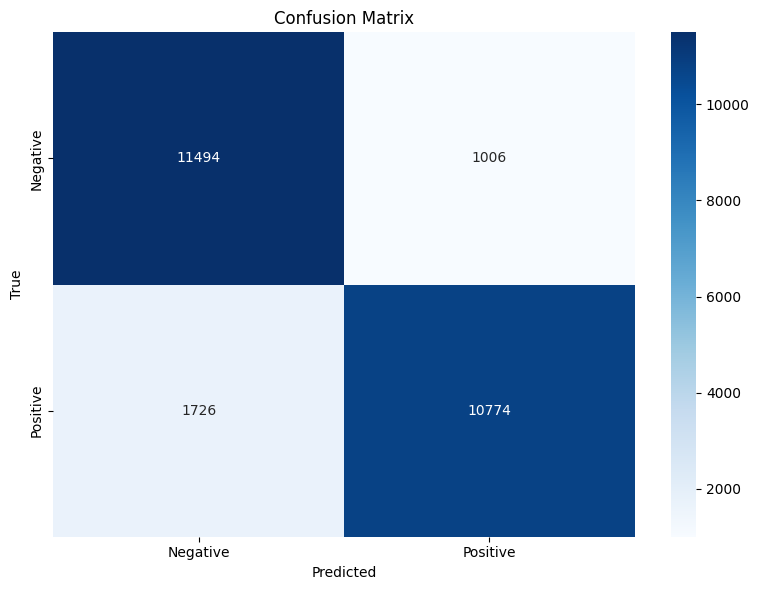

In [ ]:
cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [62]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89     12500
           1       0.91      0.86      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



In [64]:
print("F1 Score:", f1_score(test_labels, predictions, average='weighted'))
print("Accuracy:", accuracy_score(test_labels, predictions))
print("Precision:", precision_score(test_labels, predictions, average='weighted'))
print("Recall:", recall_score(test_labels, predictions, average='weighted'))

F1 Score: 0.8906292835529501
Accuracy: 0.89072
Precision: 0.8920206303666052
Recall: 0.89072
